# Multinomial Naive Bayes Classifier

**Goal:** Classify a document *d* into one of *K* classes $C_k$, given its words.


## 1. Bayes' Theorem

$$
P(C_k \mid d) = \frac{P(d \mid C_k) \cdot P(C_k)}{P(d)}
$$

Since  $P(d)$ is constant across classes, we use:

$$
\arg\max_{C_k} \left[ P(d \mid C_k) \cdot P(C_k) \right]
$$


## 2. Multinomial Model

- Represent document *d* as a vector of word counts:  
- $ d = n_1, n_2, \dots, n_V $
- $V$ is the size of the vocabulary.
- $n_i$ is the number of times word $w_i$ appears in document *d*.

$$
P(d \mid C_k) = \frac{N_d!}{\prod_{i=1}^{V} n_i!} \prod_{i=1}^{V} \left( P(w_i \mid C_k) \right)^{n_i}
$$

In practice, we ignore the multinomial coefficient and compute:

$$
\log P(d \mid C_k) = \sum_{i=1}^{V} n_i \cdot \log P(w_i \mid C_k)
$$


## 3. Priors

$$
P(C_k) = \frac{\text{Number of documents in class } C_k}{\text{Total number of documents}}
$$


## 4. Likelihoods with Smoothing

$$
P(w_i \mid C_k) = \frac{N_{ik} + \alpha}{N_k + \alpha V}
$$

Where:

- $N_{ik}$ = number of times word $w_i$ occurs in documents of class $C_k$
- $N_k$ = total number of words in documents of class $C_k$
- $\alpha$ = smoothing parameter (usually $\alpha = 1$, Laplace smoothing)
- $V$ = size of vocabulary


## 5. Prediction Rule

For a given document *d*, compute for each class:

$$
\log P(C_k) + \sum_{i=1}^{V} n_i \cdot \log P(w_i \mid C_k)
$$

Choose the class with the highest score:

$$
\hat{C} = \arg\max_{C_k} \left[ \log P(C_k) + \sum_{i=1}^{V} n_i \cdot \log P(w_i \mid C_k) \right]
$$


## 6. Summary of Training Steps

1. Compute $P(C_k)$ for each class.
2. For each word $w_i$ and each class $C_k$, compute $P(w_i \mid C_k)$ with smoothing.


## 7. Summary of Prediction Steps

1. For a new document *d*, compute the score for each class.
2. Choose the class with the highest score.



---
# Load the datasets

In [78]:
# Load the required libraries
library(ggplot2)
library(tidytext)
library(dplyr)
library(tm)
library(tidyr)
library(SnowballC)
library(readr)

In [79]:
# Load the training and testing datasets
train_data = read.csv("data/original/train.csv")
test_data = read.csv("data/original/test.csv")

In [80]:
# Divide the training dataset into training and validation set. 20% of the data will be used for validation.

set.seed(42)  # For reproducibility

train_indices = sample(1:nrow(train_data), size = 0.8 * nrow(train_data))
train_data = train_data[train_indices, ]
validation_data = train_data[-train_indices, ]

In [81]:
print("--------- Training Data Summary ---------")
summarize(train_data,
          num_rows = n(), 
          num_cols = ncol(train_data),
          num_missing = sum(is.na(train_data)))

print("--------- Validation Data Summary ---------")
summarise(validation_data,
          num_rows = n(),
          num_cols = ncol(validation_data),
          num_missing = sum(is.na(validation_data)))

print("--------- Testing Data Summary ---------")
summarise(test_data,
          num_rows = n(),
          num_cols = ncol(test_data),
          num_missing = sum(is.na(test_data)))

[1] "--------- Training Data Summary ---------"


num_rows,num_cols,num_missing
<int>,<int>,<int>
8192,3,0


[1] "--------- Validation Data Summary ---------"


num_rows,num_cols,num_missing
<int>,<int>,<int>
1623,3,0


[1] "--------- Testing Data Summary ---------"


num_rows,num_cols,num_missing
<int>,<int>,<int>
1267,2,0


In [82]:
train_data = train_data %>% mutate(doc_id = row_number())
validation_data = validation_data %>% mutate(doc_id = row_number())
test_data = test_data %>% mutate(doc_id = row_number())

In [83]:
train_data$Text = as.character(train_data$Text)
validation_data$Text = as.character(validation_data$Text)
test_data$Text = as.character(test_data$Text)

In [84]:
train_data[0:5,]

,Labels,Text,Text_Tag,doc_id
,<int>,<chr>,<chr>,<int>
2369,5,This week the House of Representatives voted to remove the word lunatic from federal law.,legal-issues,1
5273,2,"Mayor Giuliani made New York City what's known as a 'sanctuary city,' where illegal aliens were allowed to come. And he instructed the leaders of the city not to enforce the law, not to enforce immigration law.",immigration,2
9290,5,"I'm proud of the fact that I've raised more money from small donors than anybody else, and that we're getting $25, $50, $100 donations, and we've done very well doing it that way.",ethics,3
1252,5,Cuyahoga County passed a program to guarantee a college savings account for every single child who enters kindergarten in this county -- the first county in the United States to do so.,education,4
8826,2,Theres now been three independent investigations (into the bridge scandal) all of which have said that Christie did not have prior knowledge of or involvement in the lane closures.,candidates-biography,5


### Possible labels of the data
- False: 1
- Half-True: 2
- Mostly-True: 3
- Not-Known: 4
- True: 5
- Barely-True: 0

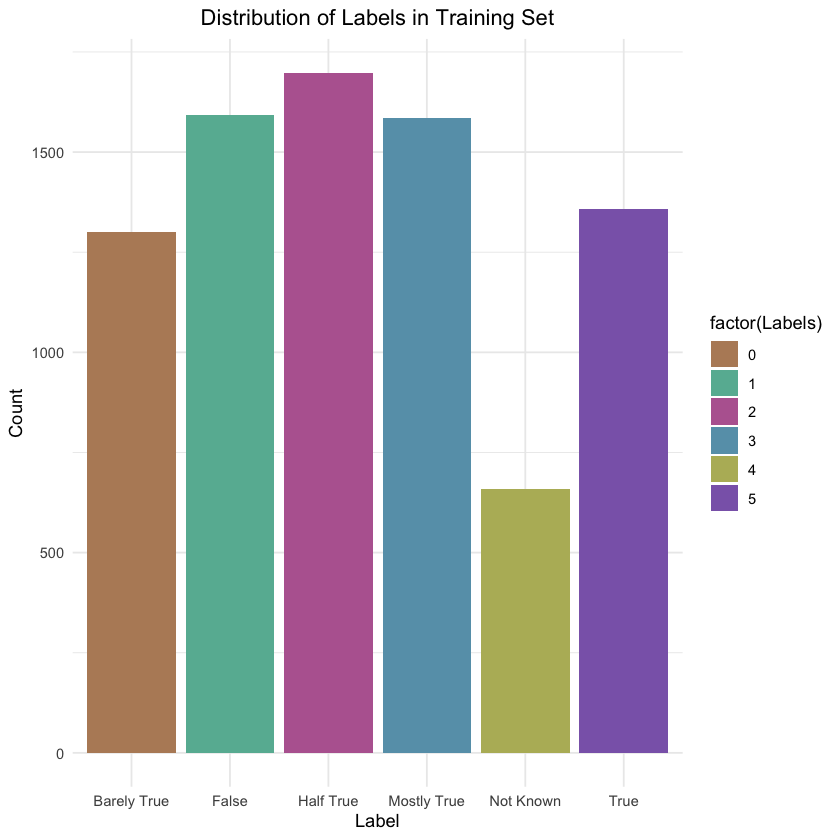

In [85]:
ggplot(train_data, aes(x = factor(Labels), fill = factor(Labels))) +
  geom_bar() +
  labs(title = "Distribution of Labels in Training Set",
       x = "Label",
       y = "Count") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5)) +
  scale_x_discrete(labels = c("0" = "Barely True", 
                               "1" = "False", 
                               "2" = "Half True", 
                               "3" = "Mostly True", 
                               "4" = "Not Known", 
                               "5" = "True")) +
  scale_fill_manual(values = c("0" = "#b78b67", 
                               "1" = "#67b7a1", 
                               "2" = "#b7679f", 
                               "3" = "#679fb7", 
                               "4" = "#b7b767", 
                               "5" = "#8b67b7"))

# Tokenization
We tokenize all of the datasets such that each datapoint will be a vector of the words it contains. All of the letters are converted into lowercase. The punctuation is removed. Stopwords such as "and", "of", or "the" are also removed. We replace numbers with a < number > placeholder unless it includes a dollar sign ($) or a percentage (%).

In [86]:
tokenize_and_clean_text <- function(data_frame, use_stemming = TRUE) {
  data_frame %>% 
    # TOKENIZE THE TEXT INTO INDIVIDUAL WORDS (TIDYTEXT)
    unnest_tokens(word, Text, drop = FALSE) %>%
    
    # REMOVE PUNCTUATION (DPLYR + REGEX)
    mutate(word = gsub("[[:punct:]]", "", word)) %>%
    
    # REPLACE NUMBERS WITH A PLACEHOLDER UNLESS THEY START WITH $ OR END WITH %
    mutate(word = ifelse(grepl("^\\$[0-9]+|[0-9]+%$", word), 
                         word, 
                         gsub("[[:digit:]]+", "<number>", word))) %>%
    
    # WORD STEMMING (PORTER STEMMING)
    { if (use_stemming) mutate(., word = wordStem(word, language = "en")) else . } %>%
    
    # REMOVE STOPWORDS
    anti_join(stop_words, by = "word") %>%
    
    # EMPTY STRINGS
    filter(word != "") %>%
    
    # SINGLE CHARACTER WORDS
    filter(nchar(word) > 1)
}


In [87]:
create_dtm <- function(tokenized_data, total_docs = NULL, tfidf = FALSE, tfidf_power = 1.0) {
  if (!all(c("doc_id", "word") %in% colnames(tokenized_data))) {
    stop("The data must contain 'doc_id' and 'word' columns.")
  }

  word_counts <- tokenized_data %>%
    count(doc_id, word)

  if (tfidf) {
    # COMPUTE TF-IDF
    doc_freq <- word_counts %>%
      group_by(word) %>%
      summarise(df = n_distinct(doc_id), .groups = "drop")

    total_docs <- n_distinct(word_counts$doc_id)

    tf_idf <- word_counts %>%
      left_join(doc_freq, by = "word") %>%
      mutate(
        tf = n,
        idf = log((total_docs + 1) / (df + 1)) + 1,
        tf_idf = (tf * idf) ^ tfidf_power
      )

    dtm <- tf_idf %>%
      select(doc_id, word, tf_idf) %>%
      cast_sparse(doc_id, word, tf_idf)

  } else {
    dtm <- word_counts %>%
      cast_sparse(doc_id, word, n)
  }

  return(dtm)
}


In [88]:
prepare_pipeline <- function(train_data, validation_data, test_data,
                             min_freq = 5,
                             use_text_tag = TRUE,
                             use_tfidf = TRUE,
                             tfidf_power = 1.0,
                             use_stemming = TRUE) {
  
  # TEXT TAG
  if (use_text_tag) {
    train_data <- train_data %>% mutate(Text = paste(Text, Text_Tag))
    validation_data <- validation_data %>% mutate(Text = paste(Text, Text_Tag))
    test_data <- test_data %>% mutate(Text = paste(Text, Text_Tag))
  }

  # 2. TOKENIZATION
  tokenized_train_data <- tokenize_and_clean_text(train_data, use_stemming = use_stemming)
  tokenized_validation_data <- tokenize_and_clean_text(validation_data, use_stemming = use_stemming)
  tokenized_test_data <- tokenize_and_clean_text(test_data, use_stemming = use_stemming)


  # FILTER OUT LOW FREQUENCY VOCAB
  vocab <- tokenized_train_data %>%
    count(word) %>%
    filter(n >= min_freq) %>%
    pull(word)

  tokenized_train_data <- tokenized_train_data %>% filter(word %in% vocab)
  tokenized_validation_data <- tokenized_validation_data %>% filter(word %in% vocab)
  tokenized_test_data <- tokenized_test_data %>% filter(word %in% vocab)

  # CREATE DTM
  training_matrix <- create_dtm(tokenized_train_data, tfidf = use_tfidf, tfidf_power = tfidf_power)
  validation_matrix <- create_dtm(tokenized_validation_data, tfidf = use_tfidf, tfidf_power = tfidf_power)
  test_matrix <- create_dtm(tokenized_test_data, total_docs = nrow(test_data), tfidf = use_tfidf, tfidf_power = tfidf_power)

  training_matrix <- as.matrix(training_matrix)
  validation_matrix <- as.matrix(validation_matrix)
  test_matrix <- as.matrix(test_matrix)
  

  return(list(
    training_matrix = training_matrix,
    validation_matrix = validation_matrix,
    test_matrix = test_matrix,
    vocab = vocab,
    tokenized_train_data = tokenized_train_data
  ))
}


# Naive Bayes Classifier Main Functions

$$\hat{C} = \arg\max_{C_k} \left[ \log P(C_k) + \sum_{i=1}^{V} n_i \cdot \log P(w_i \mid C_k) \right]$$

In [89]:
predict_naive_bayes <- function(matrix, priors, log_likelihoods, classes) {
  predictions <- vector("character", nrow(matrix))
  vocab <- colnames(matrix)
  
  for (i in 1:nrow(matrix)) {
    doc <- as.numeric(matrix[i, ])
    names(doc) <- colnames(matrix)  # IMPORTANT FOR WORD-BASED LOOKUP
    scores <- sapply(classes, function(class) {
      shared_words <- intersect(vocab, names(log_likelihoods[[class]]))
      if (length(shared_words) == 0) return(-Inf)
      sum(doc[shared_words] * log_likelihoods[[class]][shared_words]) + log(priors[class])
    })
    predictions[i] <- classes[which.max(scores)]
  }
  
  return(predictions)
}

train_naive_bayes <- function(training_matrix, train_labels,
                              validation_matrix, validation_labels,
                              laplace = 1.0) {
  training_matrix <- as.matrix(training_matrix)
  validation_matrix <- as.matrix(validation_matrix)

  train_labels <- as.factor(train_labels)
  validation_labels <- as.factor(validation_labels)
  classes <- levels(train_labels)

  priors <- table(train_labels) / length(train_labels)

  likelihoods <- list()
  for (class in classes) {
    class_rows <- training_matrix[train_labels == class, , drop = FALSE]
    word_totals <- colSums(class_rows) + laplace
    likelihoods[[class]] <- word_totals / sum(word_totals)
  }

  epsilon <- 1e-10
  vocab <- colnames(training_matrix)
  log_likelihoods <- list()
  for (class in classes) {
    log_likelihoods[[class]] <- sapply(vocab, function(word) {
      if (word %in% names(likelihoods[[class]])) {
        log(likelihoods[[class]][[word]])
      } else {
        log(epsilon)
      }
    })
  }

  validation_predictions <- predict_naive_bayes(validation_matrix,
                                                priors,
                                                log_likelihoods,
                                                classes)

  confusion_matrix <- table(Predicted = validation_predictions, Actual = validation_labels)
  accuracy <- sum(diag(confusion_matrix)) / sum(confusion_matrix)

  print("Confusion Matrix:")
  print(confusion_matrix)
  print(paste("Validation Accuracy:", round(accuracy * 100, 2), "%"))

  return(list(
    priors = priors,
    likelihoods = likelihoods,
    log_likelihoods = log_likelihoods,
    classes = classes,
    predictions = validation_predictions,
    confusion_matrix = confusion_matrix
  ))
}


## TD-IDF and Laplace smoothing


--- tfidf_power = 0.1 ---
[1] "Confusion Matrix:"
         Actual
Predicted   0   1   2   3   4   5
        0 139  14  11  15  11   9
        1  24 195  19  16  22  21
        2  37  40 254  45  16  35
        3  40  33  38 226  12  36
        4   3   2   3   0  62   0
        5  15  13  25  19   6 167
[1] "Validation Accuracy: 64.26 %"

--- tfidf_power = 0.2 ---
[1] "Confusion Matrix:"
         Actual
Predicted   0   1   2   3   4   5
        0 149  15  10  15  10  10
        1  20 199  18  13  19  19
        2  33  37 254  42  15  34
        3  34  29  37 228  11  33
        4   5   4   6   2  69   0
        5  17  13  25  21   5 172
[1] "Validation Accuracy: 65.99 %"

--- tfidf_power = 0.3 ---
[1] "Confusion Matrix:"
         Actual
Predicted   0   1   2   3   4   5
        0 158  16  11  16   9  10
        1  18 201  18  15  15  17
        2  24  35 247  38  15  32
        3  33  27  39 230   9  31
        4   7   5   7   3  77   1
        5  18  13  28  19   4 177
[1] "Validation

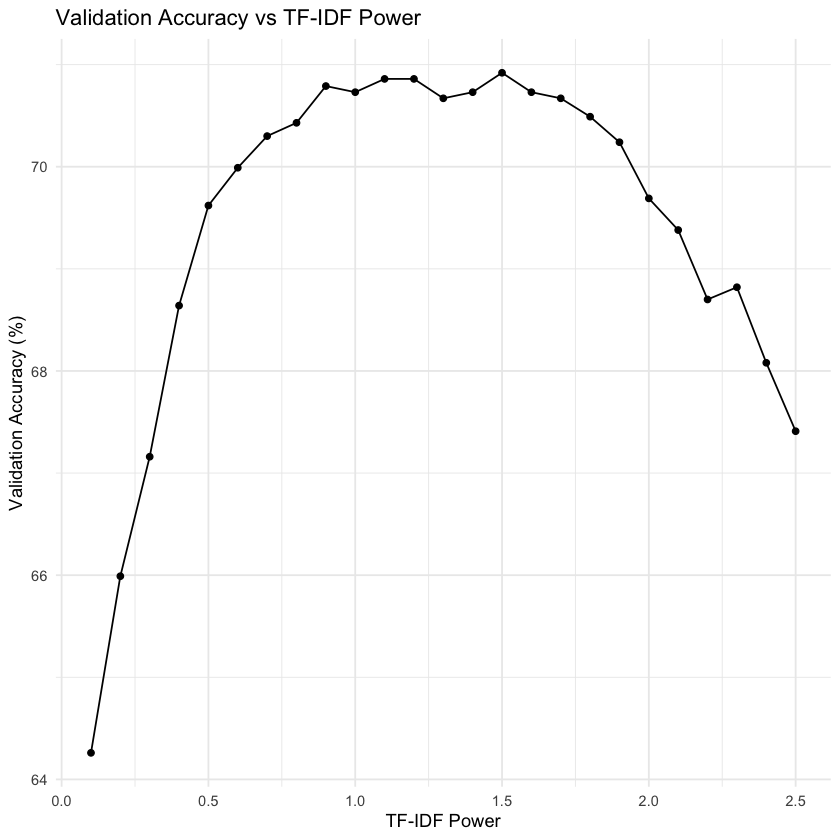

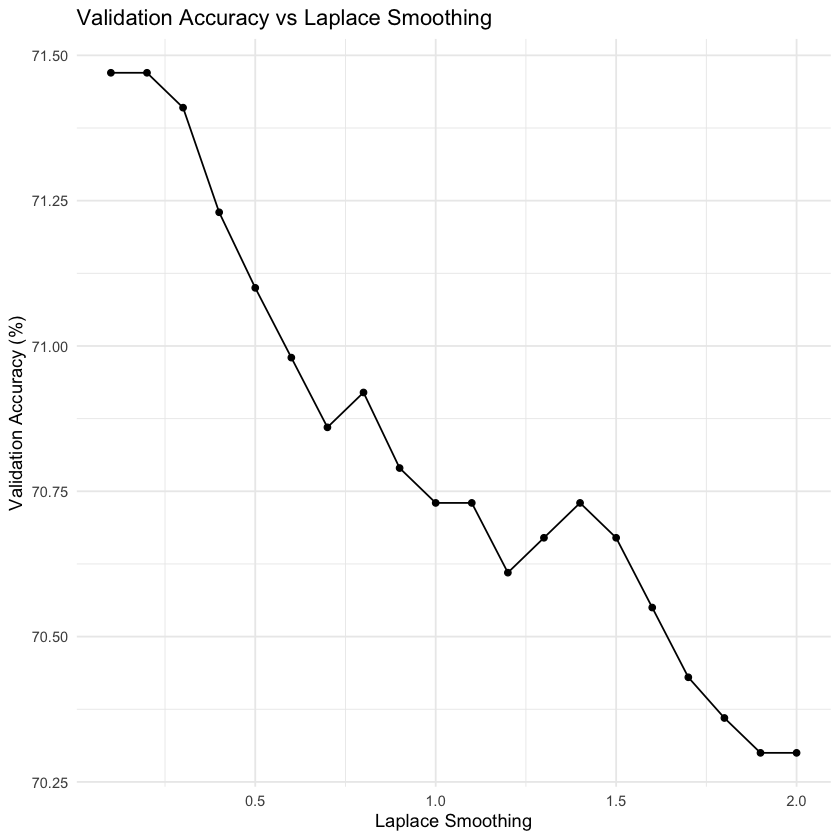

In [90]:
# FIXED PARAMETERS
fixed_min_freq     <- 1
fixed_use_text_tag <- FALSE
fixed_use_tfidf    <- TRUE
fixed_use_stemming <- TRUE

# VALUES TO TEST
tfidf_power_values <- seq(0.1, 2.5, 0.1)
laplace_values <- seq(0, 2.0, 0.1)
 
# STORE RESULTS
results_power <- data.frame(tfidf_power = numeric(), validation_accuracy = numeric())
results_laplace <- data.frame(laplace = numeric(), validation_accuracy = numeric())

# LOOP FOR TF-IDF POWER
for (tfidf_power in tfidf_power_values) {
  cat("\n--- tfidf_power =", tfidf_power, "---\n")
  tryCatch({
    result <- prepare_pipeline(train_data, validation_data, test_data,
                               min_freq = fixed_min_freq,
                               use_text_tag = fixed_use_text_tag,
                               use_tfidf = fixed_use_tfidf,
                               tfidf_power = tfidf_power,
                               use_stemming = fixed_use_stemming)

    train_indices <- as.integer(rownames(result$training_matrix))
    val_indices   <- as.integer(rownames(result$validation_matrix))
    train_labels_aligned <- train_data$Labels[train_indices]
    val_labels_aligned   <- validation_data$Labels[val_indices]

    model <- train_naive_bayes(result$training_matrix,
                               train_labels_aligned,
                               result$validation_matrix,
                               val_labels_aligned,
                               laplace = 1.0)

    acc <- sum(diag(model$confusion_matrix)) / sum(model$confusion_matrix)

    results_power <- rbind(results_power, data.frame(
      tfidf_power = tfidf_power,
      validation_accuracy = round(acc * 100, 2)
    ))

  }, error = function(e) {
    cat("⚠️ tfidf_power error:", e$message, "\n")
  })
}

# Loop for laplace
for (laplace in laplace_values) {
  cat("\n--- laplace =", laplace, "---\n")
  tryCatch({
    result <- prepare_pipeline(train_data, validation_data, test_data,
                               min_freq = fixed_min_freq,
                               use_text_tag = fixed_use_text_tag,
                               use_tfidf = fixed_use_tfidf,
                               tfidf_power = 1.0,
                               use_stemming = fixed_use_stemming)

    train_indices <- as.integer(rownames(result$training_matrix))
    val_indices   <- as.integer(rownames(result$validation_matrix))
    train_labels_aligned <- train_data$Labels[train_indices]
    val_labels_aligned   <- validation_data$Labels[val_indices]

    model <- train_naive_bayes(result$training_matrix,
                               train_labels_aligned,
                               result$validation_matrix,
                               val_labels_aligned,
                               laplace = laplace)

    acc <- sum(diag(model$confusion_matrix)) / sum(model$confusion_matrix)

    results_laplace <- rbind(results_laplace, data.frame(
      laplace = laplace,
      validation_accuracy = round(acc * 100, 2)
    ))

  }, error = function(e) {
    cat("⚠️ laplace error:", e$message, "\n")
  })
}

# Plot: Validation Accuracy vs tfidf_power
ggplot(results_power, aes(x = tfidf_power, y = validation_accuracy)) +
  geom_point() +
  geom_line() +
  labs(title = "Validation Accuracy vs TF-IDF Power",
       x = "TF-IDF Power", y = "Validation Accuracy (%)") +
  theme_minimal()

# Plot: Validation Accuracy vs Laplace
ggplot(results_laplace, aes(x = laplace, y = validation_accuracy)) +
  geom_point() +
  geom_line() +
  labs(title = "Validation Accuracy vs Laplace Smoothing",
       x = "Laplace Smoothing", y = "Validation Accuracy (%)") +
  theme_minimal()


# Varying hyperparameter configurations

In [91]:
# DEFINE HYPERPARAMETER GRID
min_freq_values     <- c(1, 2) # MINIMUM WORD FREQUENCY THRESHOLD FOR VOCABULARY INCLUSION
use_text_tag_values <- c(TRUE, FALSE) # APPEND THE TEXT-TAG TO THE TEXT BEFORE TOKENIZATION
use_tfidf_values    <- c(TRUE, FALSE) # USE TERM FREQUENCY * INVERSE DOCUMENT FREQUENCY WEIGHTS
tfidf_power_values  <- c(0.01, 0.1, 1.0) # THE STRENGTH OF THE TF-IDF
laplace_values      <- c(0.01, 0.1, 1.0) # LAPLACE SMOOTHING PARAMETER
use_stemming_values <- c(TRUE, FALSE) # WORD STEMMING, USE ONLY THE STEMS OF EACH WORD

# RESULTS STORAGE
results <- data.frame(
  min_freq = integer(),
  use_text_tag = logical(),
  use_tfidf = logical(),
  laplace = numeric(),
  tfidf_power = numeric(),
  use_stemming = logical(),
  validation_accuracy = numeric(),
  stringsAsFactors = FALSE
)

# BEST MODEL INITIALIZATION
best_model <- NULL
best_result <- NULL
best_acc <- 0
best_config <- list()

# GRID SEARCH LOOP
for (min_freq in min_freq_values) {
  for (use_text_tag in use_text_tag_values) {
    for (use_tfidf in use_tfidf_values) {
      for (laplace in laplace_values) {
        for (tfidf_power in tfidf_power_values) {
          for (use_stemming in use_stemming_values) {

            cat("\n--- Running with:",
                "min_freq =", min_freq,
                "| use_text_tag =", use_text_tag,
                "| use_tfidf =", use_tfidf,
                "| laplace =", laplace,
                "| tfidf_power =", tfidf_power,
                "| use_stemming =", use_stemming, "---\n")

            tryCatch({

              # PREPARE MATRICES
              result <- prepare_pipeline(train_data, validation_data, test_data,
                                         min_freq = min_freq,
                                         use_text_tag = use_text_tag,
                                         use_tfidf = use_tfidf,
                                         tfidf_power = tfidf_power,
                                         use_stemming = use_stemming)

              # ALIGN LABELS
              train_indices <- as.integer(rownames(result$training_matrix))
              val_indices   <- as.integer(rownames(result$validation_matrix))

              train_labels_aligned <- train_data$Labels[train_indices]
              val_labels_aligned   <- validation_data$Labels[val_indices]

              # TRAIN MODEL
              model <- train_naive_bayes(result$training_matrix,
                                         train_labels_aligned,
                                         result$validation_matrix,
                                         val_labels_aligned,
                                         laplace = laplace)

              # COMPUTE ACCURACY
              acc <- sum(diag(model$confusion_matrix)) / sum(model$confusion_matrix)

              # SAVE RESULTS
              results <- rbind(results, data.frame(
                min_freq = min_freq,
                use_text_tag = use_text_tag,
                use_tfidf = use_tfidf,
                laplace = laplace,
                tfidf_power = tfidf_power,
                use_stemming = use_stemming,
                validation_accuracy = round(acc * 100, 2)
              ))

              # SAVE BEST MODEL
              if (acc > best_acc) {
                best_acc <- acc
                best_model <- model
                best_result <- result
                best_config <- list(
                  min_freq = min_freq,
                  use_text_tag = use_text_tag,
                  use_tfidf = use_tfidf,
                  laplace = laplace,
                  tfidf_power = tfidf_power,
                  use_stemming = use_stemming
                )
              }

            }, error = function(e) {
              cat("Skipped config due to error:", e$message, "\n")
            })
          }
        }
      }
    }
  }
}

# Print summary
cat("\nBest validation accuracy:", round(best_acc * 100, 2), "%\n")
print(best_config)

cat("Best Configuration:\n")
print(best_config)

# Save results if needed
print(results)



--- Running with: min_freq = 1 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.01 | tfidf_power = 0.01 | use_stemming = TRUE ---
[1] "Confusion Matrix:"
         Actual
Predicted   0   1   2   3   4   5
        0 175  14  15  12   7  10
        1  15 210  19  15   6  17
        2  18  27 256  35  10  23
        3  31  16  34 231   5  25
        4   6   8   7   3  97   5
        5  13  22  19  25   4 188
[1] "Validation Accuracy: 71.29 %"

--- Running with: min_freq = 1 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.01 | tfidf_power = 0.01 | use_stemming = FALSE ---
[1] "Confusion Matrix:"
         Actual
Predicted   0   1   2   3   4   5
        0 202  18   6   8   2   9
        1   7 235  10  11   4  11
        2  19  14 291  23   7  13
        3  18  17  19 259   7  20
        4   4   0   5   5 104   5
        5   8  13  19  15   5 210
[1] "Validation Accuracy: 80.16 %"

--- Running with: min_freq = 1 | use_text_tag = TRUE | use_tfidf = TRUE | laplace = 0.01 | tfidf_p

### Comparison of hyperparameters

In [119]:
results[results$validation_accuracy == max(results$validation_accuracy), ]

,min_freq,use_text_tag,use_tfidf,laplace,tfidf_power,use_stemming,validation_accuracy
,<dbl>,<lgl>,<lgl>,<dbl>,<dbl>,<lgl>,<dbl>
56,1,FALSE,FALSE,0.01,0.01,FALSE,80.35
58,1,FALSE,FALSE,0.01,0.10,FALSE,80.35
60,1,FALSE,FALSE,0.01,1.00,FALSE,80.35


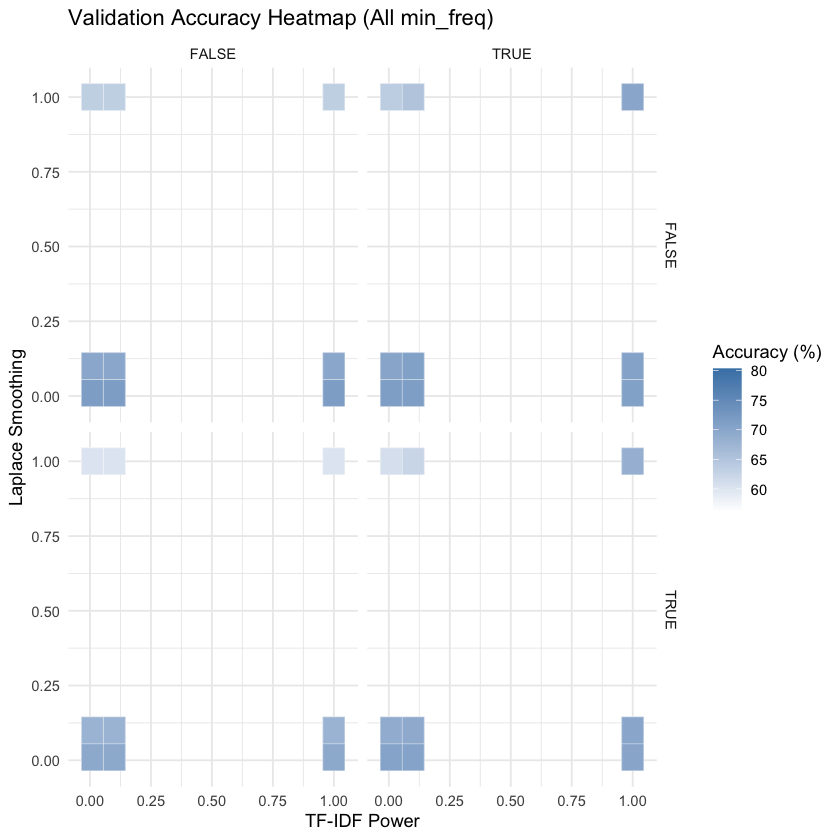

In [118]:
ggplot(results, aes(x = tfidf_power, y = laplace, fill = validation_accuracy)) +
  geom_tile(color = "white") +
  facet_grid(use_text_tag ~ use_tfidf) +
  scale_fill_gradient(low = "white", high = "steelblue") +
  labs(
    title = "Validation Accuracy Heatmap (All min_freq)",
    x = "TF-IDF Power",
    y = "Laplace Smoothing",
    fill = "Accuracy (%)"
  ) +
  theme_minimal()

## Confusion matrix of the best model

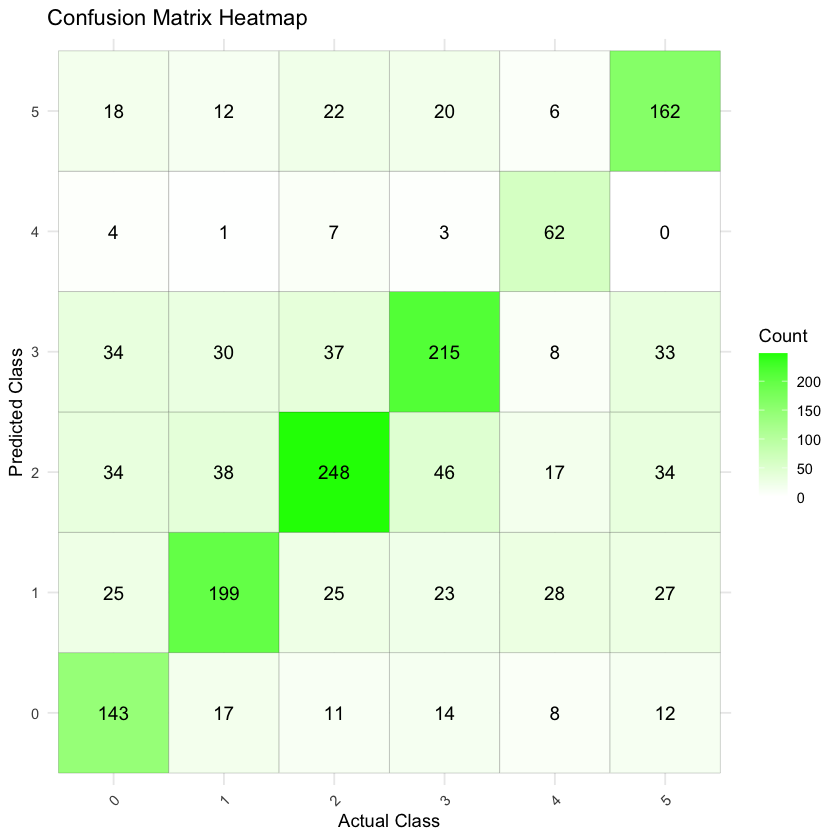

In [93]:
confusion_matrix = model$confusion_matrix

cm_df <- as.data.frame(confusion_matrix)
colnames(cm_df) <- c("Predicted", "Actual", "Count")

ggplot(cm_df, aes(x = Actual, y = Predicted, fill = Count)) +
  geom_tile(color = "black", linewidth = 0.05) +
  geom_text(aes(label = Count), color = "black", size = 4) +
  scale_fill_gradient(low = "white", high = "green") +
  theme_minimal() +
  labs(title = "Confusion Matrix Heatmap",
       x = "Actual Class",
       y = "Predicted Class") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


# Test evaluation

In [94]:
test_indices <- as.integer(rownames(best_result$test_matrix))
test_texts <- test_data$Text[test_indices]

# PREDICTION
test_predictions <- predict_naive_bayes(
  best_result$test_matrix,
  best_model$priors,
  best_model$log_likelihoods,
  names(best_model$priors)
)

print("🏁 Best Config:")
print(best_config)




[1] "<U+0001F3C1> Best Config:"
$min_freq
[1] 1

$use_text_tag
[1] FALSE

$use_tfidf
[1] FALSE

$laplace
[1] 0.01

$tfidf_power
[1] 0.01

$use_stemming
[1] FALSE



In [95]:
table(test_predictions)

test_predictions
  0   1   2   3   4   5 
202 242 261 278  76 207 

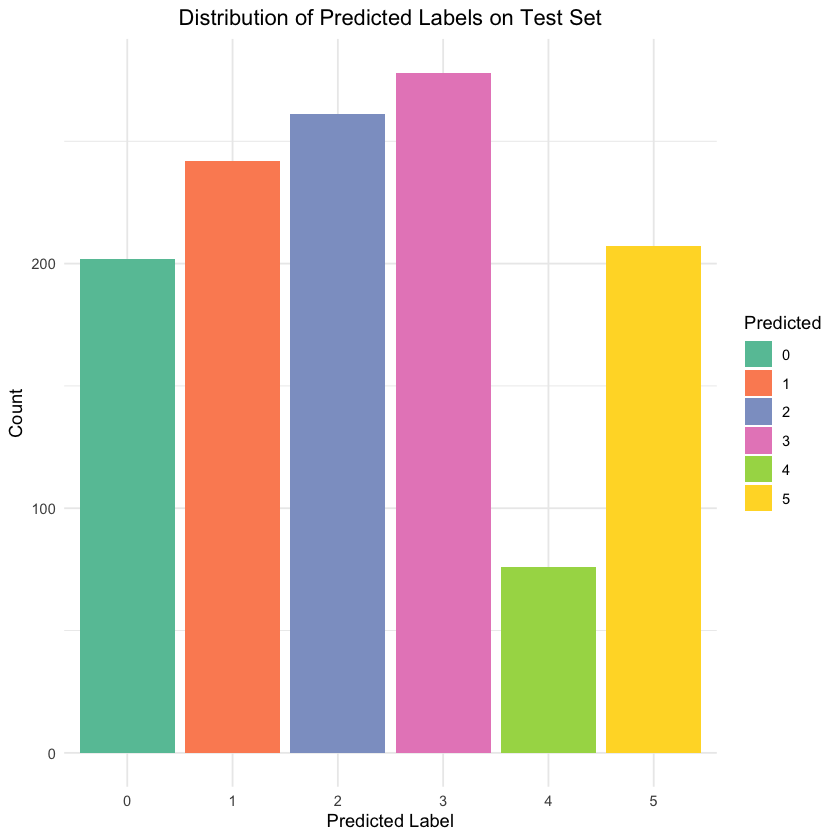

In [96]:
# Convert to data frame
pred_df <- data.frame(Predicted = test_predictions)

# Plot
ggplot(pred_df, aes(x = Predicted, fill = Predicted)) +
  geom_bar() +
  labs(title = "Distribution of Predicted Labels on Test Set",
       x = "Predicted Label",
       y = "Count") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5)) +
  scale_fill_brewer(palette = "Set2")


In [97]:
label_names <- c(
  "Barely-True",  # 0
  "False",        # 1
  "Half-True",    # 2
  "Mostly-True",  # 3
  "Not-Known",    # 4
  "True"          # 5
)

# Safely match rownames of test_matrix back to test_data
test_doc_ids <- as.integer(rownames(best_result$test_matrix))
row_matches <- match(test_doc_ids, test_data$doc_id)

# Ensure valid rows
valid_rows <- !is.na(row_matches)
test_doc_ids <- test_doc_ids[valid_rows]
row_matches <- row_matches[valid_rows]

# Get aligned test data
test_df <- test_data[row_matches, ]

# Coerce to integer before indexing
predicted_numeric <- as.integer(test_predictions[valid_rows])

# Construct the result table
results_table <- data.frame(
  doc_id = test_doc_ids,
  Text = test_df$Text,
  Text_Tag = test_df$Text_Tag,
  Predicted_Label = predicted_numeric,
  Predicted_Label_Name = label_names[predicted_numeric + 1]
)


# View
results_table[0:30,]


,doc_id,Text,Text_Tag,Predicted_Label,Predicted_Label_Name
,<int>,<chr>,<chr>,<int>,<chr>
1,1,Building a wall on the U.S.-Mexico border will take literally years.,immigration,2,Half-True
2,2,Wisconsin is on pace to double the number of layoffs this year.,jobs,1,False
3,3,Says John McCain has done nothing to help the vets.,"military,veterans,voting-record",2,Half-True
4,4,Suzanne Bonamici supports a plan that will cut choice for Medicare Advantage seniors.,"medicare,message-machine-2012,campaign-advertising",1,False
5,5,"When asked by a reporter whether hes at the center of a criminal scheme to violate campaign laws, Gov. Scott Walker nodded yes.","campaign-finance,legal-issues,campaign-advertising",1,False
6,6,Over the past five years the federal government has paid out $601 million in retirement and disability benefits to deceased former federal employees.,"federal-budget,pensions,retirement",5,True
7,7,Says that Tennessee law requires that schools receive half of proceeds -- $31 million per year -- from a half-cent increase in the Shelby County sales tax.,"county-budget,county-government,education,taxes",1,False
8,8,"Says Vice President Joe Biden ""admits that the American people are being scammed"" with the economic stimulus package.","economy,stimulus",1,False
9,9,Donald Trump is against marriage equality. He wants to go back.,"gays-and-lesbians,marriage",3,Mostly-True


# Binary classification

In [98]:
fake_data <- read.csv("data/binary/News_dataset/Fake.csv", stringsAsFactors = FALSE)
real_data <- read.csv("data/binary/News_dataset/True.csv", stringsAsFactors = FALSE)

In [99]:
fake_data$label <- 0  # 0 FOR FAKE
real_data$label <- 1  # 1 FOR REAL

binary_data <- rbind(fake_data, real_data)

set.seed(42)
binary_data <- binary_data[sample(nrow(binary_data)), ]

binary_data_clean <- binary_data[, c("title", "subject", "label")]
colnames(binary_data_clean) <- c("Text", "Text_Tag", "Labels")

We only include true, mostly-true, false, and pants-fire as labels to convert for avoiding overlap between more uncertain labels. This helps our labels to have more certainty.

In [100]:
set.seed(42)

# PROPORTIONS: 80% TRAIN, 10% VALIDATION, 10% TEST
n <- nrow(binary_data_clean)
binary_train_index <- 1:floor(0.8 * n)
binary_val_index   <- (max(binary_train_index) + 1):(max(binary_train_index) + floor(0.1 * n))
binary_test_index  <- (max(binary_val_index) + 1):n

# CREATING SPLITS
binary_train_data      <- binary_data_clean[binary_train_index, ]
binary_validation_data <- binary_data_clean[binary_val_index, ]
binary_test_data       <- binary_data_clean[binary_test_index, ]

# ASSIGNING DOC_IDS FOR DTM CREATION
binary_train_data$doc_id      <- 1:nrow(binary_train_data)
binary_validation_data$doc_id <- 1:nrow(binary_validation_data)
binary_test_data$doc_id       <- 1:nrow(binary_test_data)


In [101]:
table(binary_data_clean$Label)


    0     1 
23481 21417 

In [102]:
# TEXT NORMALIZATION (DUE TO DIFFERENCES FROM THE FIRST DATASET)
clean_text_column <- function(text) {
  text <- iconv(text, from = "", to = "UTF-8", sub = " ")           # REPLACE INVALID BYTES
  text <- gsub("[^[:print:]]", " ", text)                            # REMOVE NON-PRINTABLE CHARS
  text <- gsub("\\s+", " ", text)                                   # NORMALIZE WHITESPACE
  text <- trimws(text)                                              # TRIM SPACES
  return(text)
}

binary_data_clean$Text <- clean_text_column(binary_data_clean$Text)


In [103]:
binary_data_clean

,Text,Text_Tag,Labels
,<chr>,<chr>,<dbl>
34020,Florida Gov. Scott not endorsing 2016 Republican presidential candidate,politicsNews,1
8826,Fox News Host Calls For American Muslims With Links To ISIS To Be Executed Without Trial (VIDEO),News,0
16740,WHAT S SO WRONG WITH TRANSGENDER BATHROOMS? This Guy Has The Awesome Answer!,Government News,0
7700,Highly Ranked Draft Prospect Asked By NFL Coach If He Was Gay During Meeting,News,0
36722,Saudi-led air strikes support Yemen's Saleh as he shifts against Houthis,worldnews,1
9091,U2 s LIMOUSINE LIBERAL BONO Proves He s Clueless On Trump: Bleakest Era,politics,0
33700,House Speaker Ryan attacks Obama trip to Cuba,politicsNews,1
13610,BOOM! MEXICAN AMERICAN TRUMP Supporter Explains Difference Between ILLEGAL And LEGAL Citizens: She (Hillary) Is A Criminal [VIDEO],politics,0
40094,Catalan government to appeal direct rule in constitutional court,worldnews,1


## Grid search on dataset 2 (binary)

In [ ]:
# DEFINE HYPERPARAMETER GRID
binary_min_freq_values     <- c(2,3) # KEEP THIS ABOVE 2. OTHERWISE R MEMORY OVERLOADS
binary_use_text_tag_values <- c(TRUE, FALSE)
binary_use_tfidf_values    <- c(TRUE, FALSE)
binary_tfidf_power_values  <- c(0.01, 0.1, 1.0)
binary_laplace_values      <- c(0.01, 0.1, 1.0)
binary_use_stemming_values <- c(TRUE, FALSE)

# RESULTS STORAGE
binary_results <- data.frame(
  min_freq = integer(),
  use_text_tag = logical(),
  use_tfidf = logical(),
  laplace = numeric(),
  tfidf_power = numeric(),
  use_stemming = logical(),
  validation_accuracy = numeric(),
  stringsAsFactors = FALSE
)

# BEST MODEL INITIALIZATION
binary_best_model   <- NULL
binary_best_result  <- NULL
binary_best_acc     <- 0
binary_best_config  <- list()

# GRID SEARCH LOOP
for (min_freq in binary_min_freq_values) {
  for (use_text_tag in binary_use_text_tag_values) {
    for (use_tfidf in binary_use_tfidf_values) {
      for (laplace in binary_laplace_values) {
        for (tfidf_power in binary_tfidf_power_values) {
          for (use_stemming in binary_use_stemming_values) {

            cat("\n--- Binary config:",
                "min_freq =", min_freq,
                "| use_text_tag =", use_text_tag,
                "| use_tfidf =", use_tfidf,
                "| laplace =", laplace,
                "| tfidf_power =", tfidf_power,
                "| use_stemming =", use_stemming, "---\n")

            tryCatch({

              # PREPARE THE DATA
              binary_result <- prepare_pipeline(
                binary_train_data, binary_validation_data, binary_test_data,
                min_freq = min_freq,
                use_text_tag = use_text_tag,
                use_tfidf = use_tfidf,
                tfidf_power = tfidf_power,
                use_stemming = use_stemming
              )

              # ALIGN LABELS
              train_idx <- as.integer(rownames(binary_result$training_matrix))
              val_idx   <- as.integer(rownames(binary_result$validation_matrix))

              train_labels <- binary_train_data$Labels[train_idx]
              val_labels   <- binary_validation_data$Labels[val_idx]

              # MODEL TRAINING
              binary_model <- train_naive_bayes(
                binary_result$training_matrix,
                train_labels,
                binary_result$validation_matrix,
                val_labels,
                laplace = laplace
              )

              # ACCURACY CALCULATION
              binary_acc <- sum(diag(binary_model$confusion_matrix)) / sum(binary_model$confusion_matrix)

              # Save run
              binary_results <- rbind(binary_results, data.frame(
                min_freq = min_freq,
                use_text_tag = use_text_tag,
                use_tfidf = use_tfidf,
                laplace = laplace,
                tfidf_power = tfidf_power,
                use_stemming = use_stemming,
                validation_accuracy = round(binary_acc * 100, 2)
              ))

              # SAVE THE BEST MODEL
              if (binary_acc > binary_best_acc) {
                binary_best_acc     <- binary_acc
                binary_best_model   <- binary_model
                binary_best_result  <- binary_result
                binary_best_config  <- list(
                  min_freq = min_freq,
                  use_text_tag = use_text_tag,
                  use_tfidf = use_tfidf,
                  laplace = laplace,
                  tfidf_power = tfidf_power,
                  use_stemming = use_stemming
                )
              }

            }, error = function(e) {
              cat("⚠️ Skipped due to error:", e$message, "\n")
            })
          }
        }
      }
    }
  }
}

# Results summary
cat("\n Best Validation Accuracy:", round(binary_best_acc * 100, 2), "%\n")
cat(" Best Configuration:\n")
print(binary_best_config)

# Print all results
print(binary_results)


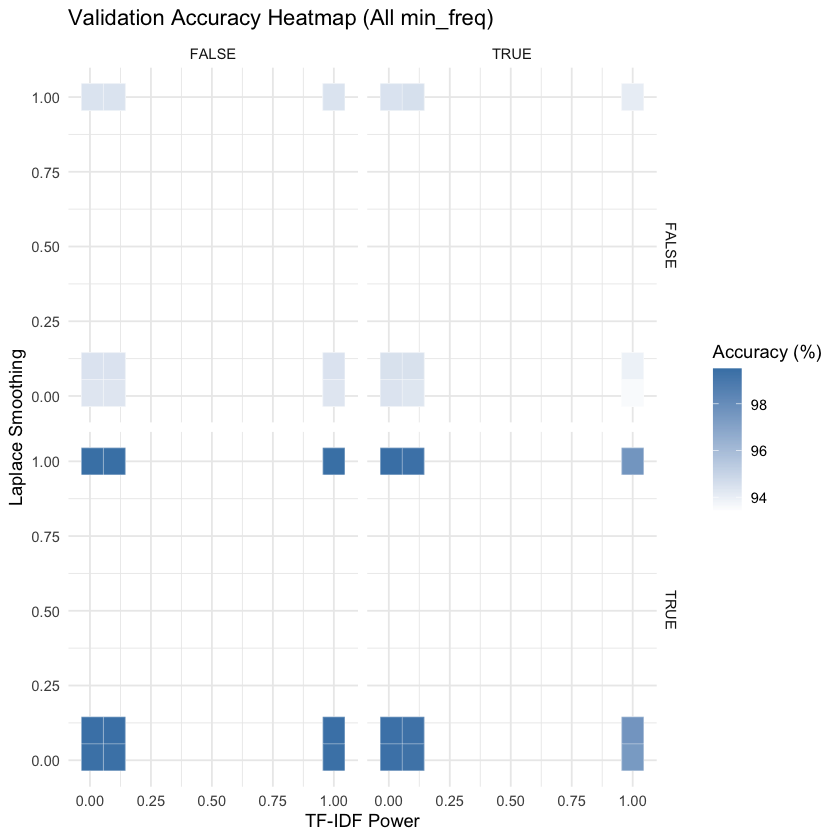

In [117]:
ggplot(binary_results, aes(x = tfidf_power, y = laplace, fill = validation_accuracy)) +
  geom_tile(color = "white") +
  facet_grid(use_text_tag ~ use_tfidf) +
  scale_fill_gradient(low = "white", high = "steelblue") +
  labs(
    title = "Validation Accuracy Heatmap (All min_freq)",
    x = "TF-IDF Power",
    y = "Laplace Smoothing",
    fill = "Accuracy (%)"
  ) +
  theme_minimal()




In [116]:
binary_results[binary_results$validation_accuracy == max(binary_results$validation_accuracy), ]

,min_freq,use_text_tag,use_tfidf,laplace,tfidf_power,use_stemming,validation_accuracy
,<dbl>,<lgl>,<lgl>,<dbl>,<dbl>,<lgl>,<dbl>
19,2,TRUE,FALSE,0.01,0.01,TRUE,99.51
21,2,TRUE,FALSE,0.01,0.10,TRUE,99.51
23,2,TRUE,FALSE,0.01,1.00,TRUE,99.51
25,2,TRUE,FALSE,0.10,0.01,TRUE,99.51
27,2,TRUE,FALSE,0.10,0.10,TRUE,99.51
29,2,TRUE,FALSE,0.10,1.00,TRUE,99.51
31,2,TRUE,FALSE,1.00,0.01,TRUE,99.51
33,2,TRUE,FALSE,1.00,0.10,TRUE,99.51
35,2,TRUE,FALSE,1.00,1.00,TRUE,99.51


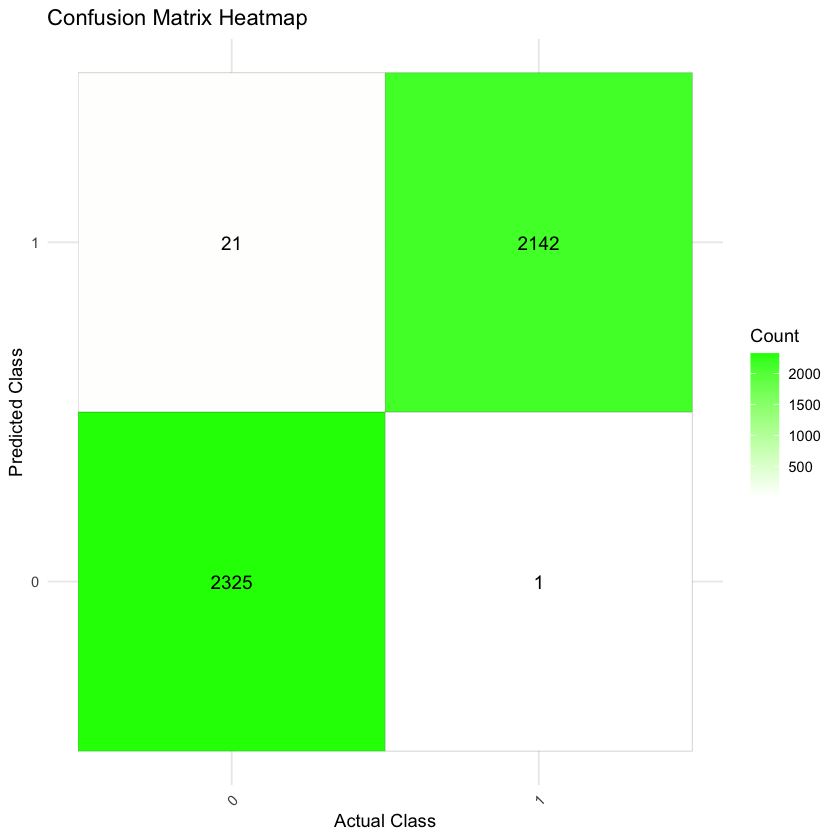

In [105]:
confusion_matrix <- binary_best_model$confusion_matrix

cm_df <- as.data.frame(confusion_matrix)
colnames(cm_df) <- c("Predicted", "Actual", "Count")

ggplot(cm_df, aes(x = Actual, y = Predicted, fill = Count)) +
  geom_tile(color = "black", linewidth = 0.05) +
  geom_text(aes(label = Count), color = "black", size = 4) +
  scale_fill_gradient(low = "white", high = "green") +
  theme_minimal() +
  labs(title = "Confusion Matrix Heatmap",
       x = "Actual Class",
       y = "Predicted Class") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))



 Final Test Accuracy: 99.47 %


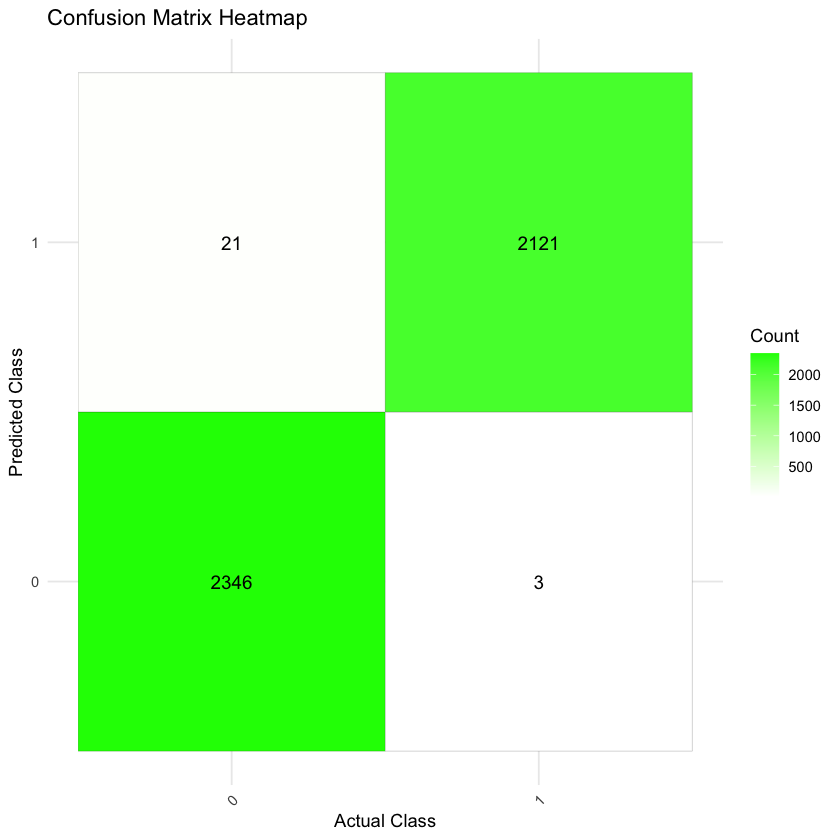

In [106]:
test_indices <- as.integer(rownames(binary_best_result$test_matrix))
test_texts <- binary_test_data$Text[test_indices]

test_predictions <- predict_naive_bayes(
  binary_best_result$test_matrix,
  binary_best_model$priors,
  binary_best_model$log_likelihoods,
  names(binary_best_model$priors)
)

test_labels <- binary_test_data$Labels[test_indices]
conf_matrix <- table(Predicted = test_predictions, Actual = test_labels)

# CONVERT TO DATAFRAME FOR PLOTTING
conf_df <- as.data.frame(conf_matrix)
colnames(conf_df) <- c("Predicted", "Actual", "Count")


ggplot(conf_df, aes(x = Actual, y = Predicted, fill = Count)) +
  geom_tile(color = "black", linewidth = 0.05) +
  geom_text(aes(label = Count), color = "black", size = 4) +
  scale_fill_gradient(low = "white", high = "green") +
  theme_minimal() +
  labs(title = "Confusion Matrix Heatmap",
       x = "Actual Class",
       y = "Predicted Class") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

test_acc <- sum(diag(conf_matrix)) / sum(conf_matrix)
cat(sprintf("\n Final Test Accuracy: %.2f %%\n", test_acc * 100))

